In [81]:
%autoreload 2
import sys
sys.path.append('src')
import sqra
import numpy as np
import ajc
import ajcs
from scipy.linalg import expm


In [ ]:
plt.set_cmap("bone_r")

In [255]:
class PaperPlots:
    def __init__(self, model):
        self.model = model
        self.Qs = model.Qs
        self.dt = model.dt

        self.ajc = ajc.AJCGalerkin(np.dstack(self.Qs), self.dt)
        self.nt = np.size(Qs, 2)
        self.nx = np.size(Qs, 0)
    
    ######

    def jumpactivity(self, p0):
        return self.ajc.geiger(p0)

    def sync(self, p0):
        pp = self.jumpactivity(p0)
        return self.ajc.synchronize(pp)

    def koopman_sync(self):
            k = np.zeros((self.nx, self.nx))
            for i in range(self.nx):
                x0 = np.zeros((self.nt, self.nx))
                x0[0,i] = 1
                k[i, :] = self.sync(x0)[:,-1]
            return k

    def koopman_q(self):
        k = np.identity(self.nx)
        for (i,t) in enumerate(self.dt):
            k = k @ expm(t * self.Qs[i])
        return k

    def koopman_error(self):
        ks = self.koopman_sync()
        kq = self.koopman_q()
        return np.linalg.norm(ks-kq, 2)

    #######

    def plot_transkernel(self):
        p = plt.imshow(self.ajc.km)

        cb = plt.colorbar()
        cb.set_label("transition probability")
        plt.xticks()
        plt.yticks()
        plt.xlabel("X x T")
        plt.ylabel("X x T")
        return p

    def plot_jumpactivity(self, x0=0):
        p0 = np.zeros((self.nt,self.nx))
        p0[0,x0] = 1

        p = plt.imshow(self.jumpactivity(p0))

        cb = plt.colorbar()
        cb.set_label("jump activity")

        plt.ylabel("X")
        plt.xlabel("t")
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.xticks(np.arange(self.nt+1) -.5, np.hstack([0,np.cumsum(self.dt)]));
        return p

    def plot_sync(self, x0=0):
        p0 = np.zeros((self.nt,self.nx))
        p0[0,x0] = 1
        ps = self.sync(p0)

        p = plt.imshow(ps)

        cb = plt.colorbar()
        cb.set_label("probability (synchronized, one state)")

        plt.ylabel("X")
        plt.xlabel("t")
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.xticks(np.arange(self.nt+1) -.5, np.hstack([0,np.cumsum(self.dt)]));
        return p

    def plot_koopman_sync(self):
        plt.imshow(self.koopman_sync())

        plt.xlabel("X")
        plt.ylabel("X")
        plt.xticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))

        cb = plt.colorbar()
        t2 = sum(self.dt)
        t1 = t2 - self.dt[-1]
        cb.set_label(f"probability (synchronized, t $\in  [{t1},{t2}]  $)")

    def plot_koopman_q(self):
        plt.imshow(self.koopman_q())
        plt.xlabel("X")
        plt.ylabel("X")

        plt.xticks(np.arange(self.nx), np.arange(1,self.nx+1))
        plt.yticks(np.arange(self.nx), np.arange(1,self.nx+1))

        cb = plt.colorbar()
        cb.set_label(f"probability (exact, t={t2})")
        plt.savefig("dwkoopexact.png")

    def plot_all(self):
        self.plot_transkernel()
        self.plot_jumpactivity(0)
        self.plot_sync(0)
        self.plot_koopman_sync()
        self.plot_koopman_q()


In [258]:
PaperPlots(d)

AssertionError: 

In [140]:
class doublewell:
    def __init__(self, nx = 5, ny = 1, xlims=(-1.5,1.5), ylims=(-1.5,1.5), dt=1, nt=4, auto=True):
        xs = np.linspace(*xlims, nx)
        ys = np.linspace(*ylims, ny)
        self.xs, self.ys = np.meshgrid(xs, ys, sparse=True)

        self.u = (self.xs**2-1)**2 + self.ys**2
        self.nt = nt
        self.nx = nx * ny
        self.dt = np.repeat(dt, nt)

        if auto:
            self.get_Qs()
            self.get_ajc()

    def get_Qs(self, **kwargs):
        self.sqra = sqra.Sqra(self.u, **kwargs)
        self.Qs = [self.sqra.Q.toarray()]*len(self.dt)

    
    def get_ajc(self):
        self.ajc = ajc.AJCGalerkin(np.dstack(self.Qs), np.array(self.dt))
        self.ajcs = ajcs.AJCS(self.Qs, self.dt)
        self.km = ajcs.flatten_spacetime(self.ajcs.k).toarray()

        def jumpfix(p):
            return np.reshape(p.flatten() @ self.km, p.shape)

        #self.ajcs.jump = jumpfix

    def jumpactivity(self, p0):
        return self.ajcs.geiger(p0)

    def sync(self, p0):
        pp = self.jumpactivity(p0)
        return self.ajc.synchronize(pp.T)

    def koopman_sync(self):
        k = np.zeros((self.nx, self.nx))
        for i in range(self.nx):
            x0 = np.zeros((self.nt, self.nx))
            x0[0,i] = 1
            k[i, :] = self.sync(x0)[:,-1]
        return k

    def koopman_q(self):
        k = np.identity(self.nx)
        for (i,t) in enumerate(self.dt):
            k = k @ expm(t * self.Qs[i])
        return k

    def koopman_error(self):
        ks = self.koopman_sync()
        kq = self.koopman_q()
        return np.linalg.norm(ks-kq, 2)

d = doublewell()

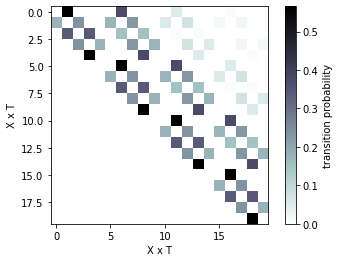

In [141]:
import matplotlib.pyplot as plt
plt.set_cmap("bone_r")
plt.imshow(d.km)

cb = plt.colorbar()
cb.set_label("transition probability")
plt.xticks()
plt.yticks()
plt.xlabel("X x T")
plt.ylabel("X x T")
plt.savefig("dwtranskernel.png")

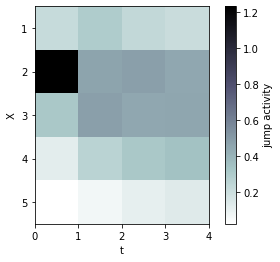

In [142]:
p0 = np.zeros((d.nt,d.nx))
p0[0,1] = 1
plt.imshow(d.jumpactivity(p0).T)

plt.yticks(np.arange(d.nx), np.arange(1,d.nx+1))
cb = plt.colorbar()
cb.set_label("jump activity")

plt.ylabel("X")
plt.xlabel("t")
plt.yticks(np.arange(d.nx), np.arange(1,d.nx+1))
plt.xticks(np.arange(len(d.dt)+1) -.5,np.hstack([0,np.cumsum(d.dt)]));

plt.savefig("dwjumpact.png")

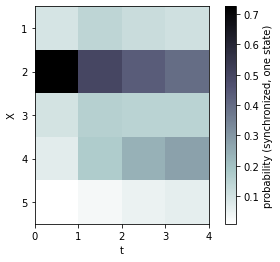

In [143]:
plt.imshow(d.sync(p0))

plt.ylabel("X")
plt.xlabel("t")

plt.yticks(np.arange(d.nx), np.arange(1,d.nx+1))
cb = plt.colorbar()
cb.set_label("probability (synchronized, one state)")


plt.yticks(np.arange(d.nx), np.arange(1,d.nx+1))
plt.xticks(np.arange(len(d.dt)+1) -.5,np.hstack([0,np.cumsum(d.dt)]));

plt.savefig("dwjumpactsync.png")

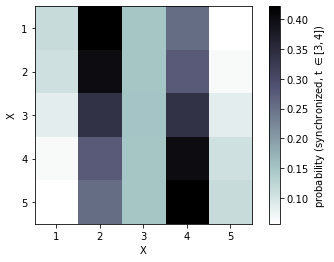

In [144]:
plt.imshow(d.koopman_sync())

plt.xlabel("X")
plt.ylabel("X")

plt.xticks(np.arange(d.nx), np.arange(1,d.nx+1))
plt.yticks(np.arange(d.nx), np.arange(1,d.nx+1))

cb = plt.colorbar()
t2 = sum(d.dt)
t1 = t2 - d.dt[-1]
cb.set_label(f"probability (synchronized, t $\in  [{t1},{t2}]  $)")

plt.savefig("dwkoopsync.png")

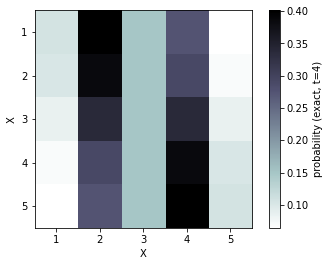

In [145]:
plt.imshow(d.koopman_q())
#plt.tight_layout()
plt.xlabel("X")
plt.ylabel("X")

plt.xticks(np.arange(d.nx), np.arange(1,d.nx+1))
plt.yticks(np.arange(d.nx), np.arange(1,d.nx+1))

cb = plt.colorbar()
cb.set_label(f"probability (exact, t={t2})")
plt.savefig("dwkoopexact.png")

In [146]:
nts = np.arange(1,30)
errors = [doublewell(nt=nt, dt=1/nt, nx=100).koopman_error() for nt in nts]

Text(0.5, 0, 'number of time cells')

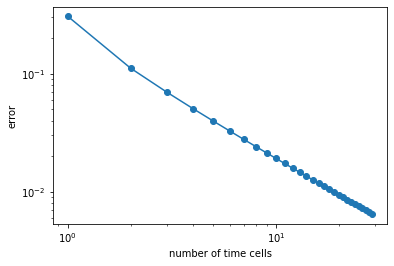

In [115]:
plt.yscale("log")
plt.xscale("log")
plt.plot(nts, errors)
plt.scatter(nts, errors)
plt.ylabel("error")
plt.xlabel("number of time cells")

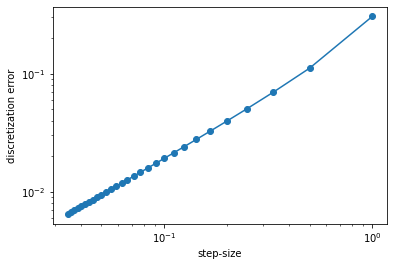

In [139]:
plt.yscale("log")
plt.xscale("log")
plt.plot(1/nts, errors)
plt.scatter(1/nts, errors)
plt.xlabel("step-size")
plt.ylabel("discretization error")
plt.savefig("dwerror.png")

In [251]:
class graph:
    def __init__(self, nt = 2, dt=1):
        self.Q1 = np.array([[-1,1],[.1,-.1]])
        self.Q2 = np.array([[-.1, .1],[1,-1]])
        self.nx = 2
        self.nt = nt
        self.Qs = np.zeros((self.nx,self.nx,self.nt))
        for i in range(nt):
            self.Qs[:,:,i] = self.Q1 if i/nt < .5 else self.Q2

        self.dt = [dt]*nt
        self.ajc = ajc.AJCGalerkin(self.Qs, np.array(self.dt))
g = graph(nt=6, dt=1)


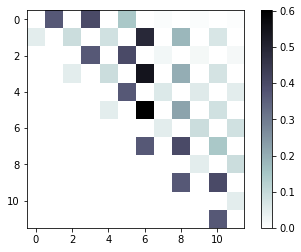

In [252]:
plt.imshow(g.ajc.km)
plt.colorbar()

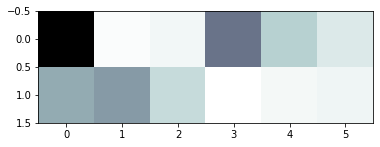

In [253]:
p0 = np.zeros((g.nt,g.nx))
p0[0,0] = 1
ja = g.ajc.geiger(p0.T)
plt.imshow(ja)

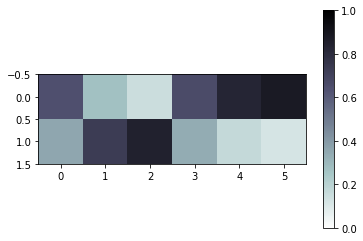

In [254]:
plt.imshow(g.ajc.synchronize(ja))
plt.colorbar()
plt.clim((0,1))